# Assignment 3: EE708
## Dhruv Gupta, 240354

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore',category='FutureWarning')
plt.style.use("ggplot")

#using sklearn for the k-means clustering part.
from sklearn.cluster import KMeans

#using scipy to just plot dendrograms (but implementing the hierarchial clustering part from scratch)
from scipy.cluster.hierarchy import dendrogram

## Problem 9
K-means clustering: Using the dataset in A3_P1.csv, implement K-means clustering and
determine the number of clusters using the Elbow method.\
a. Plot the inertia (Within-Cluster Sum of Squares - WCSS) for number of cluster
ranging from 1 to 15.\
b. Find the optimal number of clusters using the elbow method.\
c. Perform clustering using the optimal number of clusters, plot the clustering results\
with each cluster data in a different colour, and highlight the cluster centres.

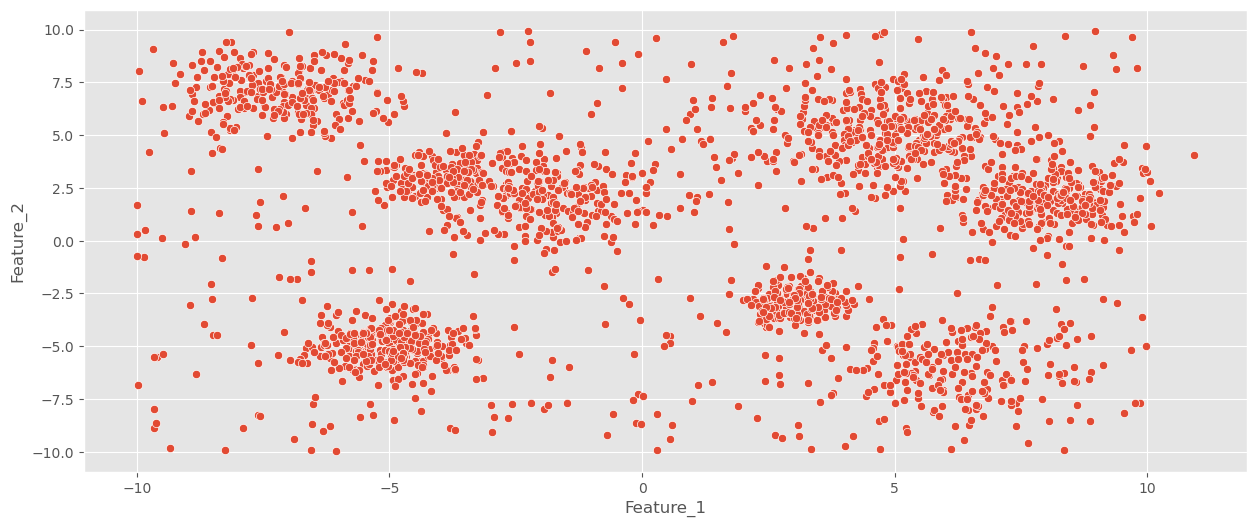

In [229]:
dt = pd.read_csv('A3_P1.csv')
X = dt.to_numpy()

plt.figure(figsize=(15,6))
sns.scatterplot(dt, x=dt['Feature_1'], y=dt['Feature_2'])
plt.show()

**Part a:** Computing inertia using within cluster sum of squared distances (WCSS)\
I computed the value of inertia for each k between 1 and 15 manually using this method:
$$ 
 \text{WCSS} = \sum_{j=1}^{k} \sum_{i \in C_{j}} \|x_{i} - \mu_{j}\|^2
$$
Where: k is the number of clusters, $\mu_{j}$ is the centre of the jth cluster, $C_{j}$

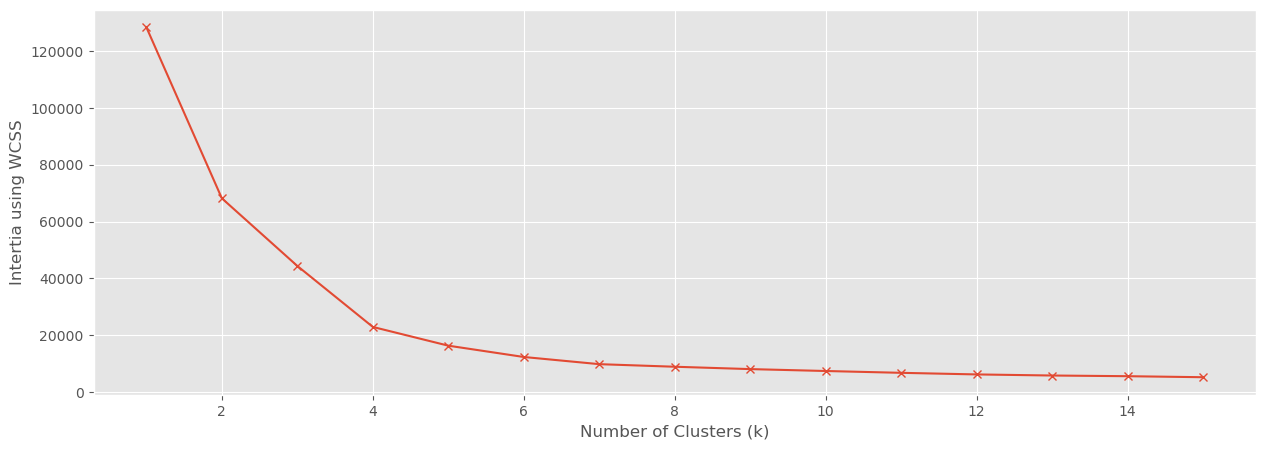

In [230]:
def wcss_inertia(X, cluster_labels, cluster_centroids):
    wcss = 0
    for index, point in enumerate(X):
        cj = cluster_labels[index] #which cluster is this point x in?
        muj = cluster_centroids[cj] #centroid of the cluster that x is part of
        
        #compute squared euclidean distance between centroid and point
        dis = (np.linalg.norm(point - muj))**2
        wcss += dis
    return wcss
    
n=15
wcssinertia = []
indices = []
for i in range(1,n+1):
    kmeansmodel = KMeans(n_clusters=i, random_state=21, n_init=10)
    kmeansmodel.fit(X)
    
    cluster_labels = kmeansmodel.labels_
    cluster_centroids = kmeansmodel.cluster_centers_
    inert = wcss_inertia(X=X, cluster_labels=cluster_labels, cluster_centroids=cluster_centroids)
    wcssinertia.append(inert)
    indices.append(i)
    
plt.figure(figsize=(15,5))    
plt.plot(indices, wcssinertia, marker='x')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Intertia using WCSS")
plt.show()
    
    

**Part b:**\
To find the optimal number of clusters, we observe this plot and then use the elbow method:\
We can see that the decrease in inertia is not that much after k=4, hence **k = 4 marks the most optimal number of clusters**.\
k = 5 also can be used as the optimal number of clusters when we want a more fine-tuned model.

**Part c:**\
We shall plot the clusters with k=4, the clusters have been plotted in different colors and the cluster centres have been highlighted by red cross marks.

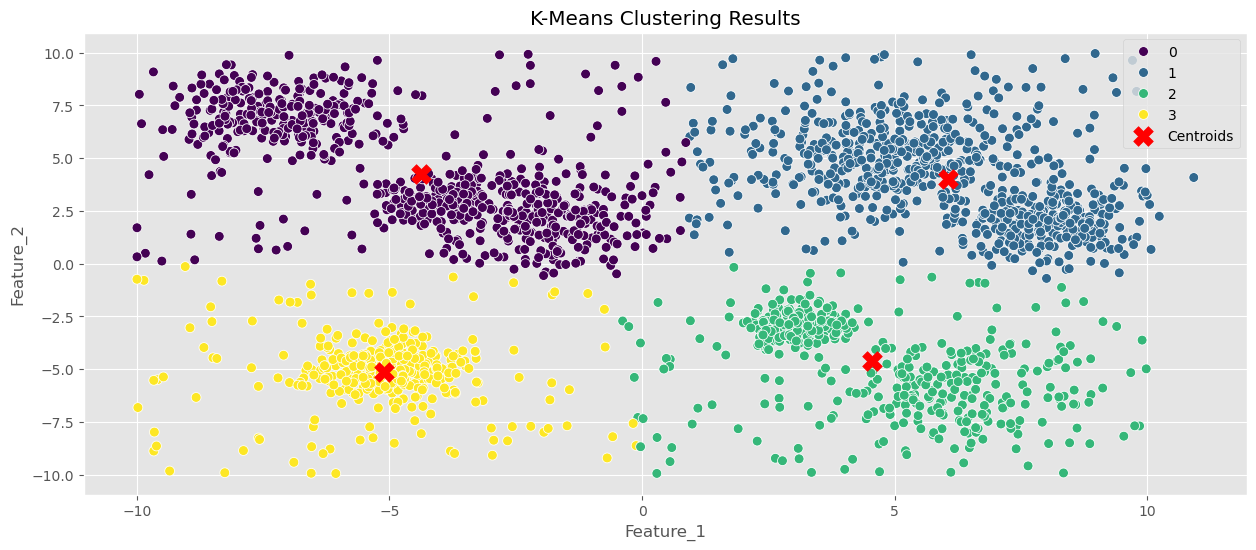

In [231]:
n_optimal = 4
kmeansmodel = KMeans(n_clusters=n_optimal, random_state=21, n_init=10)
kmeansmodel.fit(X)
training_results = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])
training_results['cluster_centers'] = kmeansmodel.labels_ #labels are names of clusters, ie, here its cluster 0, cluster 1, cluster 2
plt.figure(figsize=(15,6))
sns.scatterplot(data=training_results, x='Feature_1', y='Feature_2', hue='cluster_centers',palette='viridis',s=50)
plt.scatter(x=kmeansmodel.cluster_centers_[:,0], y=kmeansmodel.cluster_centers_[:,1], c='red', marker='X', s=200, label='Centroids')
plt.legend()
plt.title("K-Means Clustering Results")
plt.show()

## Problem 10
Hierarchical Clustering: Using the dataset in A3_P2.csv, implement bottom-up hierarchical
clustering from scratch using Euclidean distance as the distance metric. Compute the
distance between two clusters using the following methods:\
a. $D_{\min}(A,B) = \min_{u \in A, v \in B} (\delta(u, v))$   (Single-Linkage Clustering)\
b. $D_{\text{avg}}(A,B) = \left\langle \delta(u, v) \right\rangle_{u \in A, v \in B}$    (Average-Linkage Clustering)\
c. $D_{\max}(A,B) = \max_{u \in A, v \in B} (\delta(u, v))$  (Complete-Linkage Clustering)\
Plot dendrograms for each clustering method to visualize the hierarchical clustering
process.

In [232]:
def dist(p1, p2):  # Euclidean distance for 1D
    return abs(p1 - p2)

def single_link(clus1, clus2):
    return min(dist(p1,p2) for p1 in clus1 for p2 in clus2)
def average_link(clus1, clus2):
    distances = [dist(p1,p2) for p1 in clus1 for p2 in clus2]
    return sum(distances) / len(distances)
def complete_link(clus1,clus2):
    return max(dist(p1,p2) for p1 in clus1 for p2 in clus2)

def hierarchial(X, linkage):
    
    clusters = [[float(x)] for x in X] #clusters have to contain scalars
    cluster_labels = {i: [i] for i in range(len(X))}
    linkage_matrix = [] #for plotting dendrograms
    while len(clusters) > 1:
        distances = {}
        
        for i in range(len(clusters)):
            for j in range(i+1, len(clusters)):
                if linkage == "single_link":
                    distances[(i,j)] = single_link(clusters[i], clusters[j]) #stores the min distance between cluster i and cluster j in the format of (i,j) : distance
                elif linkage == "average_link":
                    distances[(i,j)] = average_link(clusters[i], clusters[j])
                elif linkage == "complete_link":
                    distances[(i,j)] = complete_link(clusters[i], clusters[j])
                else: 
                    print("please select a valid linkage type")
        
        if not distances:
            break #makes sure theres no empty dict
                    
        #now we find the closest pair of clusters to merge first
        (imerge, jmerge), min_dist = min(distances.items(), key=lambda x: x[1])
        
        #actual labels
        label_imerge = list(cluster_labels.keys())[imerge]
        label_jmerge = list(cluster_labels.keys())[jmerge]
        
        
        #make new cluster using imerge and jmerge
        new_clus = clusters[imerge] + clusters[jmerge]
        #now we have to remove the old clusters, ie, clusters[imerge] and clusters[jmerge], but before that we do linkage matrix step
        
        #record the step in linkage matrix
        #linkage matrix has entries in the form: [clus1, clus2, min_distance, length of new_cluster formed after merge]
        linkage_matrix.append([label_imerge,
                               label_jmerge,
                               min_dist,
                               len(new_clus)
                               ])
        #update cluster labels in dict
        new_label = max(cluster_labels.keys())+1
        cluster_labels[new_label] = cluster_labels[label_imerge] + cluster_labels[label_jmerge]
        
        #now we delete the old labels
        del cluster_labels[label_imerge]
        del cluster_labels[label_jmerge]
        
        #now we delete the old clusters and append the new_clus to clusters
        clusters.append(new_clus)
        clusters.pop(max(imerge,jmerge))
        clusters.pop(min(imerge,jmerge))
        
        
        
    return np.array(linkage_matrix)

**Part a:** Single Linkage Clustering 

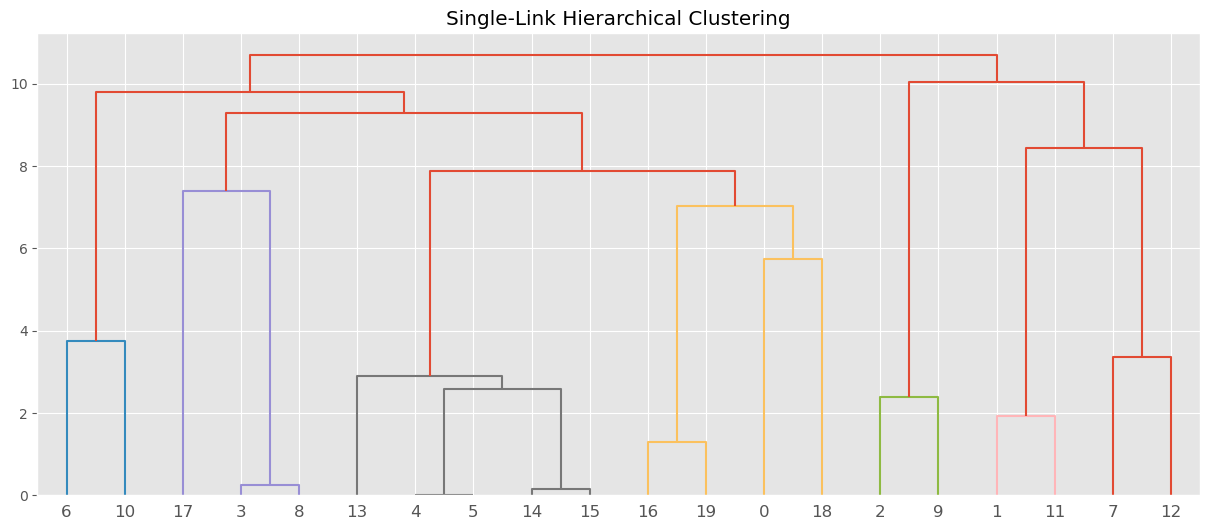

In [233]:
df = pd.read_csv("A3_P2.csv")
X = df.values.flatten() #makes sure its a 1d array

linkage_matrix = hierarchial(X, linkage="single_link")

#plot dendrogram
plt.figure(figsize=(15, 6))
dendrogram(linkage_matrix)
plt.title("Single-Link Hierarchical Clustering")
plt.show()

**Part b:** Average Link Clustering

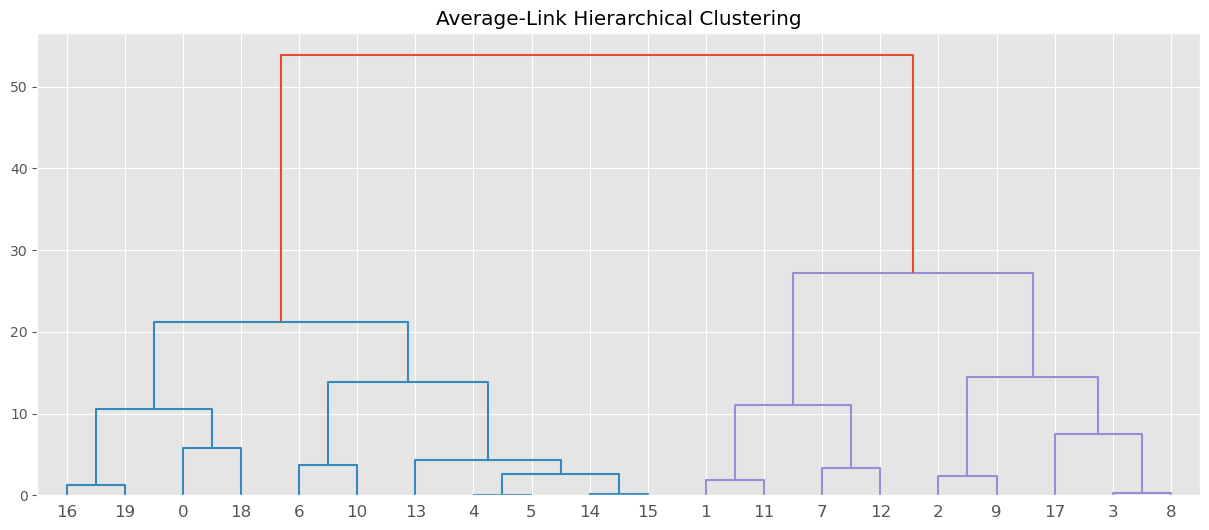

In [234]:
df = pd.read_csv("A3_P2.csv")
X = df.values.flatten() #makes sure its a 1d array

linkage_matrix = hierarchial(X, linkage="average_link")

#plot dendrogram
plt.figure(figsize=(15, 6))
dendrogram(linkage_matrix)
plt.title("Average-Link Hierarchical Clustering")
plt.show()

**Part c:** Complete-Link Hierarchial Clustering

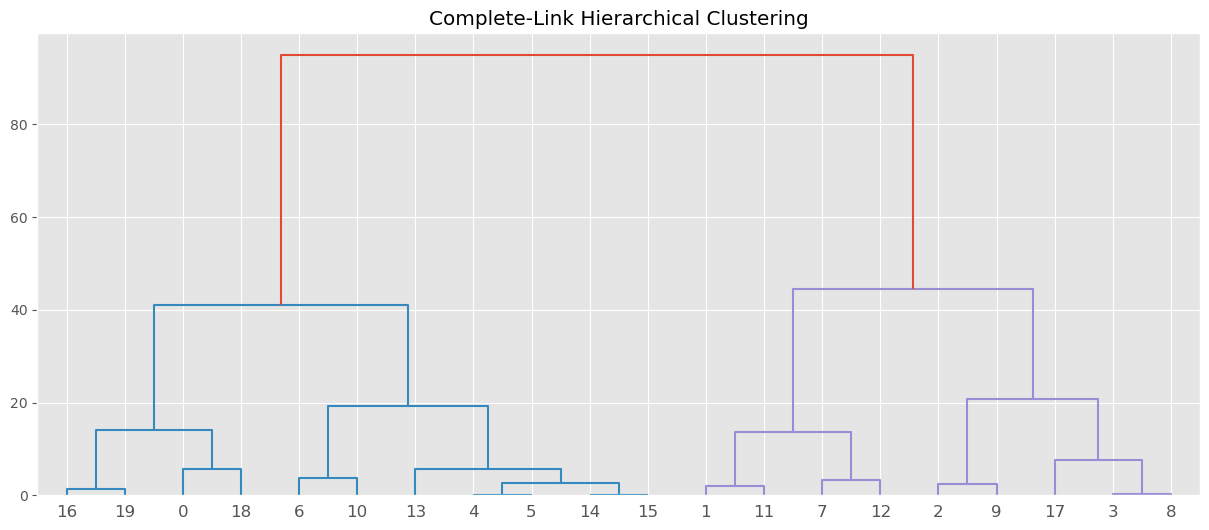

In [235]:
df = pd.read_csv("A3_P2.csv")
X = df.values.flatten() #makes sure its a 1d array

linkage_matrix = hierarchial(X, linkage="complete_link")

#plot dendrogram
plt.figure(figsize=(15, 6))
dendrogram(linkage_matrix)
plt.title("Complete-Link Hierarchical Clustering")
plt.show()